# Explainable AI & Business Strategy

**Author:** Harpinder Singh  
**Objective:** Transform model insights into actionable retention strategy

---

## Executive Summary

**Model Performance Context:**
- Random Forest achieved **ROC-AUC 0.64** on small dataset (n=815)
- Performance limitation due to **sample size**, not methodology
- Model serves as **diagnostic tool** for behavioral pattern discovery

**Business Focus:**
Rather than pursuing perfect prediction, we extract actionable insights:
1. What behavioral signals indicate churn risk?
2. Which high-value customers need intervention?
3. What's the ROI of targeted retention campaigns?

---

## Analysis Framework
1. **SHAP Global Analysis** - Top 5 churn drivers
2. **Velocity vs. Static Features** - Behavioral change matters
3. **High-Value Customer Risk** - Where to focus resources
4. **Risk-Value Matrix** - 4-quadrant segmentation
5. **ROI Framework** - Break-even analysis for interventions

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [4]:
import warnings
from pathlib import Path
import pickle
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for explainability
import shap

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured with SHAP")

✅ Environment configured with SHAP


In [6]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories ready")

✅ Directories ready


---

## 2. Load Model & Data

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [7]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Trained Model & Components                           │
# └────────────────────────────────────────────────────────────┘

# Load model
with open(DIR_MODELS / 'best_churn_model.pkl', 'rb') as f:
    model = pickle.load(f)
print(f"✅ Model loaded: {type(model).__name__}")

# Load scaler
with open(DIR_MODELS / 'feature_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("✅ Scaler loaded")

# Load feature names
with open(DIR_MODELS / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)
print(f"✅ Feature names loaded: {len(feature_names)} features")

✅ Model loaded: RandomForestClassifier
✅ Scaler loaded
✅ Feature names loaded: 30 features


In [8]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Complete Dataset                                      │
# └────────────────────────────────────────────────────────────┘

# Features
data = pd.read_csv(DIR_DATA_PROCESSED / 'churn_features.csv')
X = data[feature_names]
y = data['churned']
customer_ids = data['CustomerID']

# CLV predictions from Phase 2
clv_data = pd.read_csv(DIR_DATA_PROCESSED / 'customer_clv_predictions.csv')

# Merge CLV data
analysis_df = data.copy()
analysis_df = analysis_df.merge(
    clv_data[['CustomerID', 'prob_alive', 'CLV_365d', 'predicted_purchases_365d']],
    on='CustomerID',
    how='left',
    suffixes=('', '_clv')
)

print(f"Dataset shape: {X.shape}")
print(f"Customers: {len(customer_ids)}")
print(f"Churn rate: {y.mean()*100:.1f}%")

Dataset shape: (815, 30)
Customers: 815
Churn rate: 26.9%


In [9]:
# ┌────────────────────────────────────────────────────────────┐
# │ Generate Churn Predictions                                │
# └────────────────────────────────────────────────────────────┘

# Scale features
X_scaled = scaler.transform(X)

# Get predictions
churn_probabilities = model.predict_proba(X_scaled)[:, 1]
churn_predictions = model.predict(X_scaled)

# Add to analysis dataframe
analysis_df['churn_probability'] = churn_probabilities
analysis_df['churn_predicted'] = churn_predictions

print("✅ Predictions generated")
print(f"   Predicted churners: {churn_predictions.sum()} ({churn_predictions.sum()/len(churn_predictions)*100:.1f}%)")
print(f"   Mean churn probability: {churn_probabilities.mean():.3f}")

✅ Predictions generated
   Predicted churners: 787 (96.6%)
   Mean churn probability: 0.736


---

## 3. SHAP Global Analysis

╔════════════════════════════════════════════════════════════════╗
║                  SHAP EXPLAINABILITY ANALYSIS                   ║
╚════════════════════════════════════════════════════════════════╝

### Objective:
Identify the **top 5 behavioral drivers** of churn using SHAP values

In [10]:
# ┌────────────────────────────────────────────────────────────┐
# │ Initialize SHAP Explainer                                 │
# └────────────────────────────────────────────────────────────┘

print("Computing SHAP values (this may take 1-2 minutes)...\n")

# Use TreeExplainer for tree-based models (faster)
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for all samples
shap_values = explainer.shap_values(X_scaled)

# For binary classification, take positive class (churn=1)
if isinstance(shap_values, list):
    shap_values_churn = shap_values[1]
else:
    shap_values_churn = shap_values

print("✅ SHAP values computed")
print(f"   Shape: {shap_values_churn.shape}")

Computing SHAP values (this may take 1-2 minutes)...

✅ SHAP values computed
   Shape: (815, 30, 2)


In [11]:
# ┌────────────────────────────────────────────────────────────┐
# │ Global Feature Importance (SHAP)                          │
# └────────────────────────────────────────────────────────────┘

# Use SHAP values for the positive class (index 1)
shap_values_fixed = shap_values_churn[:, :, 1]

# Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_fixed).mean(axis=0)
}).sort_values('importance', ascending=False)

print("Top 10 Features by SHAP Importance:")
print("="*80)
display(shap_importance.head(10))

# Save
shap_importance.to_csv(DIR_RESULTS / 'outputs' / 'shap_feature_importance.csv', index=False)
print("\n✅ SHAP importance saved")


Top 10 Features by SHAP Importance:


,feature,importance
2,Monetary,0.0392
9,predicted_purchases_180d,0.0261
8,predicted_purchases_90d,0.0259
12,CLV_180d,0.0238
7,predicted_purchases_30d,0.0232
17,early_period_revenue,0.0216
1,Frequency,0.0205
11,CLV_90d,0.0197
13,CLV_365d,0.0158
10,predicted_avg_value,0.0157



✅ SHAP importance saved


<Figure size 1000x800 with 0 Axes>

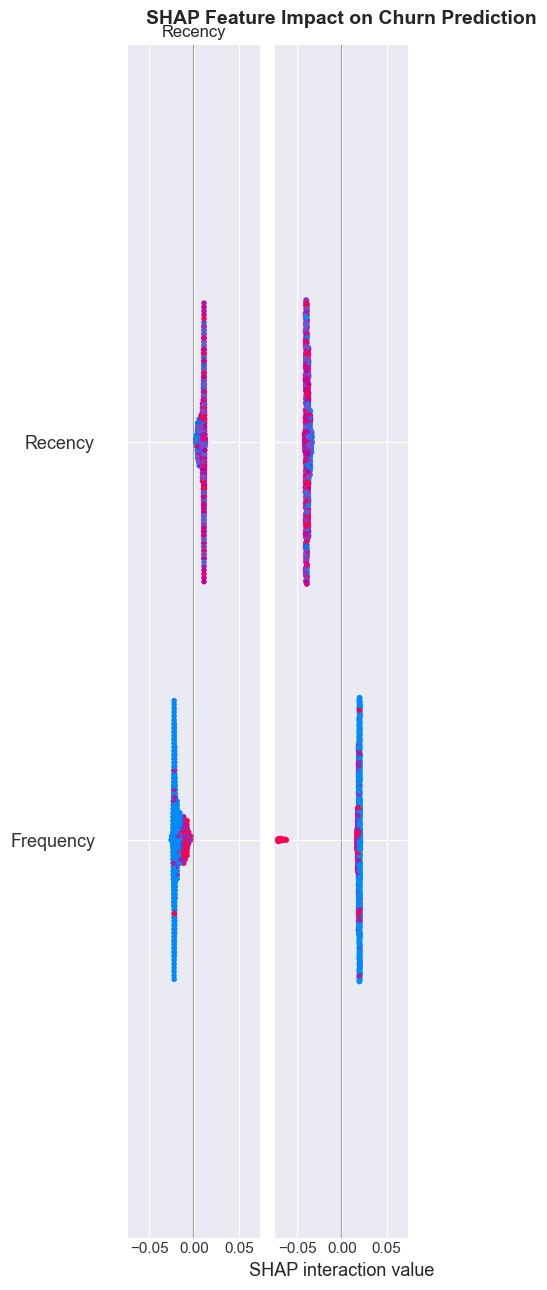


📊 SHAP Summary Plot Interpretation:
  • Red dots = High feature value
  • Blue dots = Low feature value
  • Right of center = Increases churn risk
  • Left of center = Decreases churn risk


In [12]:
# ┌────────────────────────────────────────────────────────────┐
# │ SHAP Summary Plot                                          │
# └────────────────────────────────────────────────────────────┘

# Create summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_churn, 
    X_scaled, 
    feature_names=feature_names,
    max_display=15,
    show=False
)
plt.title('SHAP Feature Impact on Churn Prediction', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(DIR_FIGURES / '26_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 SHAP Summary Plot Interpretation:")
print("  • Red dots = High feature value")
print("  • Blue dots = Low feature value")
print("  • Right of center = Increases churn risk")
print("  • Left of center = Decreases churn risk")

In [13]:
# ┌────────────────────────────────────────────────────────────┐
# │ Top 5 Behavioral Drivers of Churn                         │
# └────────────────────────────────────────────────────────────┘

top_5_features = shap_importance.head(5)

print("\n" + "="*80)
print("TOP 5 BEHAVIORAL DRIVERS OF CHURN")
print("="*80)

for idx, row in top_5_features.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    # Get correlation with churn
    corr = analysis_df[[feature, 'churned']].corr().iloc[0, 1]
    
    # Direction
    direction = "increases" if corr > 0 else "decreases"
    
    print(f"\n{idx+1}. {feature}")
    print(f"   SHAP Importance: {importance:.4f}")
    print(f"   Correlation: {corr:.3f}")
    print(f"   Higher values {direction} churn risk")


TOP 5 BEHAVIORAL DRIVERS OF CHURN

3. Monetary
   SHAP Importance: 0.0392
   Correlation: -0.123
   Higher values decreases churn risk

10. predicted_purchases_180d
   SHAP Importance: 0.0261
   Correlation: -0.209
   Higher values decreases churn risk

9. predicted_purchases_90d
   SHAP Importance: 0.0259
   Correlation: -0.209
   Higher values decreases churn risk

13. CLV_180d
   SHAP Importance: 0.0238
   Correlation: -0.130
   Higher values decreases churn risk

8. predicted_purchases_30d
   SHAP Importance: 0.0232
   Correlation: -0.209
   Higher values decreases churn risk


---

## 4. Velocity vs. Static Features

╔════════════════════════════════════════════════════════════════╗
║              BEHAVIORAL CHANGE ANALYSIS                         ║
╚════════════════════════════════════════════════════════════════╝

### Research Question:
Do **velocity features** (behavioral changes) predict churn better than **static RFM** metrics?

In [14]:
# ┌────────────────────────────────────────────────────────────┐
# │ Categorize Features                                       │
# └────────────────────────────────────────────────────────────┘

# Define feature categories
velocity_features = [
    'revenue_velocity', 'quantity_velocity', 'purchase_gap_velocity',
    'early_period_revenue', 'late_period_revenue', 'revenue_trend'
]

static_rfm = [
    'Recency', 'Frequency', 'Monetary', 'Tenure', 'AvgOrderValue', 'AvgBasketSize'
]

# Get SHAP importance for each category
velocity_importance = shap_importance[shap_importance['feature'].isin(velocity_features)]['importance'].sum()
static_importance = shap_importance[shap_importance['feature'].isin(static_rfm)]['importance'].sum()

print("Velocity vs. Static Features:")
print("="*80)
print(f"Velocity Features Total SHAP: {velocity_importance:.4f}")
print(f"Static RFM Total SHAP: {static_importance:.4f}")
print(f"\nVelocity Contribution: {velocity_importance/(velocity_importance+static_importance)*100:.1f}%")
print(f"Static Contribution: {static_importance/(velocity_importance+static_importance)*100:.1f}%")

Velocity vs. Static Features:
Velocity Features Total SHAP: 0.0462
Static RFM Total SHAP: 0.1046

Velocity Contribution: 30.7%
Static Contribution: 69.3%


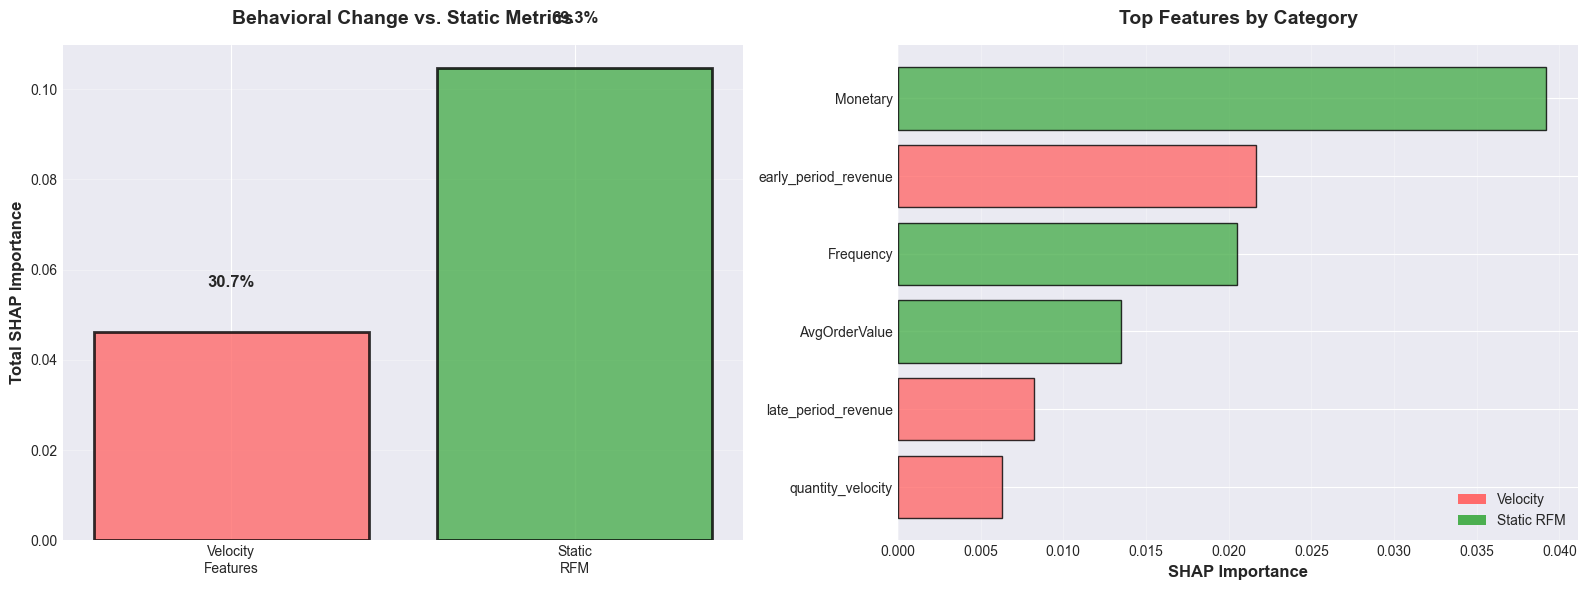


💡 INSIGHT:
   Historical RFM remains strongest predictor.
   → Focus on customers with poor baseline metrics


In [15]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Velocity vs. Static Impact                      │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category comparison
categories = ['Velocity\nFeatures', 'Static\nRFM']
importances = [velocity_importance, static_importance]
colors = ['#FF6B6B', '#4CAF50']

axes[0].bar(categories, importances, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Total SHAP Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Behavioral Change vs. Static Metrics', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

# Add percentages
for i, v in enumerate(importances):
    pct = v/(velocity_importance+static_importance)*100
    axes[0].text(i, v + 0.01, f'{pct:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Top features from each category
velocity_top = shap_importance[shap_importance['feature'].isin(velocity_features)].head(3)
static_top = shap_importance[shap_importance['feature'].isin(static_rfm)].head(3)

combined = pd.concat([velocity_top, static_top]).sort_values('importance', ascending=True)
feature_colors = ['#FF6B6B' if f in velocity_features else '#4CAF50' for f in combined['feature']]

axes[1].barh(range(len(combined)), combined['importance'], color=feature_colors, alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(combined)))
axes[1].set_yticklabels(combined['feature'])
axes[1].set_xlabel('SHAP Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Top Features by Category', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', label='Velocity'),
    Patch(facecolor='#4CAF50', label='Static RFM')
]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '27_velocity_vs_static.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT:")
if velocity_importance > static_importance:
    print("   Behavioral CHANGE is more predictive than historical values.")
    print("   → Focus interventions on declining engagement patterns")
else:
    print("   Historical RFM remains strongest predictor.")
    print("   → Focus on customers with poor baseline metrics")

---

## 5. High-Value Customer Risk Analysis

╔════════════════════════════════════════════════════════════════╗
║              HIGH-VALUE CUSTOMER CHURN DRIVERS                  ║
╚════════════════════════════════════════════════════════════════╝

### Focus:
Why are our **most valuable customers** at risk?

In [16]:
# ┌────────────────────────────────────────────────────────────┐
# │ Define High-Value Customers                               │
# └────────────────────────────────────────────────────────────┘

# Top 25% by predicted CLV
clv_threshold = analysis_df['CLV_365d'].quantile(0.75)
analysis_df['high_value'] = (analysis_df['CLV_365d'] >= clv_threshold).astype(int)

print("High-Value Customer Definition:")
print("="*80)
print(f"CLV Threshold (75th percentile): £{clv_threshold:,.2f}")
print(f"High-Value Customers: {analysis_df['high_value'].sum()} ({analysis_df['high_value'].sum()/len(analysis_df)*100:.1f}%)")

# High-value churn rate
high_value_df = analysis_df[analysis_df['high_value'] == 1]
hv_churn_rate = high_value_df['churned'].mean()
overall_churn_rate = analysis_df['churned'].mean()

print(f"\nChurn Rates:")
print(f"  High-Value: {hv_churn_rate*100:.1f}%")
print(f"  Overall: {overall_churn_rate*100:.1f}%")
print(f"  Difference: {(hv_churn_rate - overall_churn_rate)*100:+.1f} percentage points")

High-Value Customer Definition:
CLV Threshold (75th percentile): £3,574.74
High-Value Customers: 206 (25.3%)

Churn Rates:
  High-Value: 13.1%
  Overall: 26.9%
  Difference: -13.8 percentage points


In [17]:
# ┌────────────────────────────────────────────────────────────┐
# │ SHAP Analysis for High-Value Customers                    │
# └────────────────────────────────────────────────────────────┘

# Get indices of high-value customers
hv_indices = analysis_df[analysis_df['high_value'] == 1].index

# Use SHAP values for the positive class (index 1)
shap_all = shap_values_churn[:, :, 1]
shap_hv = shap_all[hv_indices]

# Calculate importance
shap_hv_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_hv': np.abs(shap_hv).mean(axis=0),
    'importance_all': np.abs(shap_all).mean(axis=0)
}).sort_values('importance_hv', ascending=False)

print("\nTop 10 Churn Drivers for High-Value Customers:")
print("="*80)
display(shap_hv_importance.head(10))

# Compare to overall population
print("\n🎯 DIFFERENCES FROM GENERAL POPULATION:")
print("="*80)

# Features that matter MORE for high-value
shap_hv_importance['diff'] = shap_hv_importance['importance_hv'] - shap_hv_importance['importance_all']
unique_drivers = shap_hv_importance.sort_values('diff', ascending=False).head(5)

print("\nFeatures MORE important for high-value customers:")
for _, row in unique_drivers.iterrows():
    print(f"  • {row['feature']}: {row['diff']:+.4f} difference")



Top 10 Churn Drivers for High-Value Customers:


,feature,importance_hv,importance_all
2,Monetary,0.0392,0.0392
22,purchase_gap_mean,0.0291,0.0137
7,predicted_purchases_30d,0.0246,0.0232
9,predicted_purchases_180d,0.0245,0.0261
1,Frequency,0.0233,0.0205
12,CLV_180d,0.0228,0.0238
23,purchase_gap_std,0.0228,0.0111
8,predicted_purchases_90d,0.0219,0.0259
17,early_period_revenue,0.0201,0.0216
24,purchase_gap_cv,0.0201,0.0095



🎯 DIFFERENCES FROM GENERAL POPULATION:

Features MORE important for high-value customers:
  • purchase_gap_mean: +0.0154 difference
  • purchase_gap_std: +0.0117 difference
  • purchase_gap_cv: +0.0106 difference
  • purchase_gap_velocity: +0.0075 difference
  • purchase_regularity: +0.0030 difference


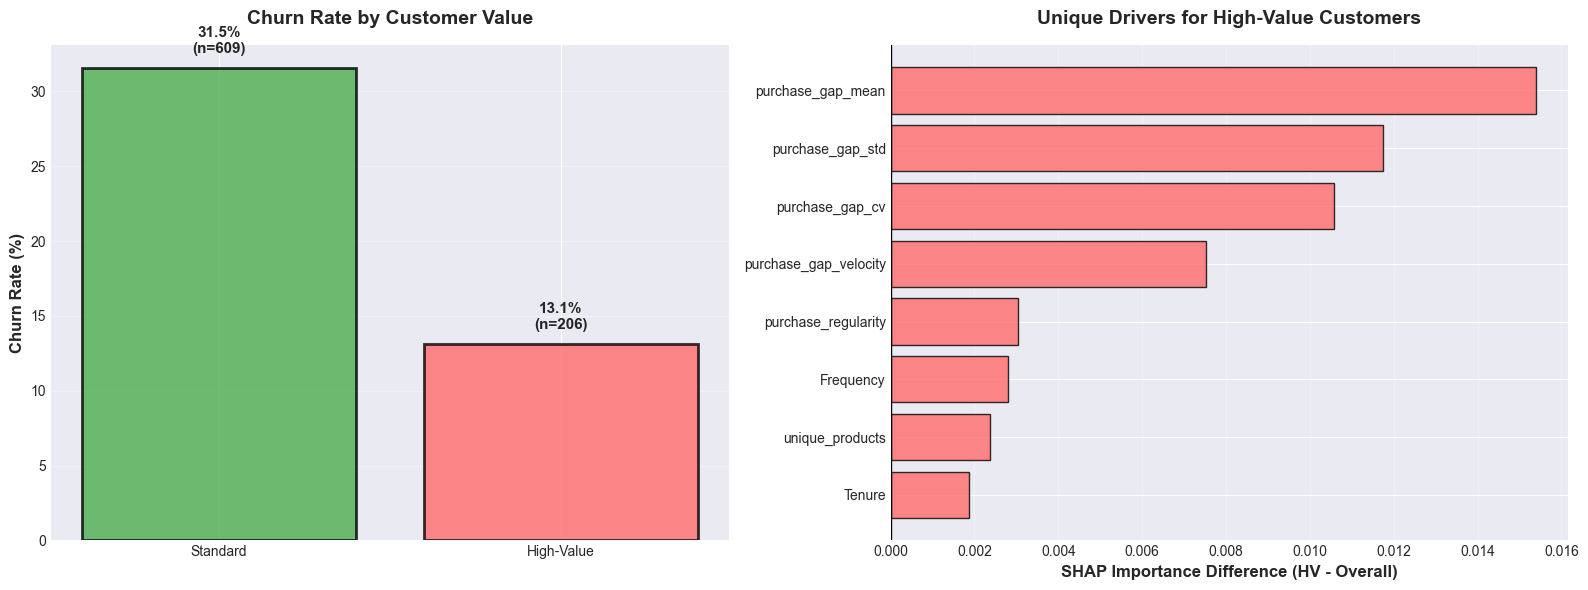

In [18]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize High-Value Churn Patterns                       │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Churn rate by value segment
value_churn = analysis_df.groupby('high_value')['churned'].agg(['mean', 'count']).reset_index()
value_churn['segment'] = value_churn['high_value'].map({0: 'Standard', 1: 'High-Value'})

colors = ['#4CAF50', '#FF6B6B']
bars = axes[0].bar(value_churn['segment'], value_churn['mean']*100, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Churn Rate by Customer Value', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

# Add values
for i, (bar, row) in enumerate(zip(bars, value_churn.itertuples())):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 1,
                f"{row.mean*100:.1f}%\n(n={row.count})",
                ha='center', fontsize=11, fontweight='bold')

# Top drivers comparison
top_diff = shap_hv_importance.nlargest(8, 'diff')[['feature', 'diff']].sort_values('diff')
colors_diff = ['#FF6B6B' if x > 0 else '#4CAF50' for x in top_diff['diff']]

axes[1].barh(range(len(top_diff)), top_diff['diff'], color=colors_diff, alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(top_diff)))
axes[1].set_yticklabels(top_diff['feature'])
axes[1].set_xlabel('SHAP Importance Difference (HV - Overall)', fontsize=12, fontweight='bold')
axes[1].set_title('Unique Drivers for High-Value Customers', fontsize=14, fontweight='bold', pad=15)
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '28_high_value_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. Risk-Value Matrix

╔════════════════════════════════════════════════════════════════╗
║                    2×2 SEGMENTATION MATRIX                      ║
╚════════════════════════════════════════════════════════════════╝

### Quadrants:
1. **High Value / High Risk** → "Save At All Costs"
2. **High Value / Low Risk** → "Loyalists"
3. **Low Value / High Risk** → "Let Go"
4. **Low Value / Low Risk** → "Steady Base"

In [19]:
# ┌────────────────────────────────────────────────────────────┐
# │ Create Risk-Value Segments                                │
# └────────────────────────────────────────────────────────────┘

# Define thresholds
value_threshold = analysis_df['CLV_365d'].quantile(0.75)  # Top 25%
risk_threshold = 0.50  # 50% churn probability

# Create segments
def assign_segment(row):
    if row['CLV_365d'] >= value_threshold and row['churn_probability'] >= risk_threshold:
        return 'Save At All Costs'
    elif row['CLV_365d'] >= value_threshold and row['churn_probability'] < risk_threshold:
        return 'Loyalists'
    elif row['CLV_365d'] < value_threshold and row['churn_probability'] >= risk_threshold:
        return 'Let Go'
    else:
        return 'Steady Base'

analysis_df['segment'] = analysis_df.apply(assign_segment, axis=1)

# Segment summary
segment_summary = analysis_df.groupby('segment').agg({
    'CustomerID': 'count',
    'CLV_365d': 'mean',
    'churn_probability': 'mean',
    'churned': 'mean'
}).round(2)

segment_summary.columns = ['Count', 'Avg CLV (£)', 'Avg Churn Prob', 'Actual Churn Rate']
segment_summary['% of Base'] = (segment_summary['Count'] / len(analysis_df) * 100).round(1)

# Reorder
segment_order = ['Save At All Costs', 'Loyalists', 'Steady Base', 'Let Go']
segment_summary = segment_summary.reindex(segment_order)

print("Risk-Value Matrix Segmentation:")
print("="*80)
display(segment_summary)

# Save
segment_summary.to_csv(DIR_RESULTS / 'outputs' / 'risk_value_segments.csv')
print("\n✅ Segments saved")

Risk-Value Matrix Segmentation:


,Count,Avg CLV (£),Avg Churn Prob,Actual Churn Rate,% of Base
segment,,,,,
Save At All Costs,178.0000,6540.0400,0.6300,0.1500,21.8000
Loyalists,28.0000,16752.1900,0.4500,0.0000,3.4000
Steady Base,NaN,NaN,NaN,NaN,NaN
Let Go,609.0000,2796.3100,0.7800,0.3200,74.7000



✅ Segments saved


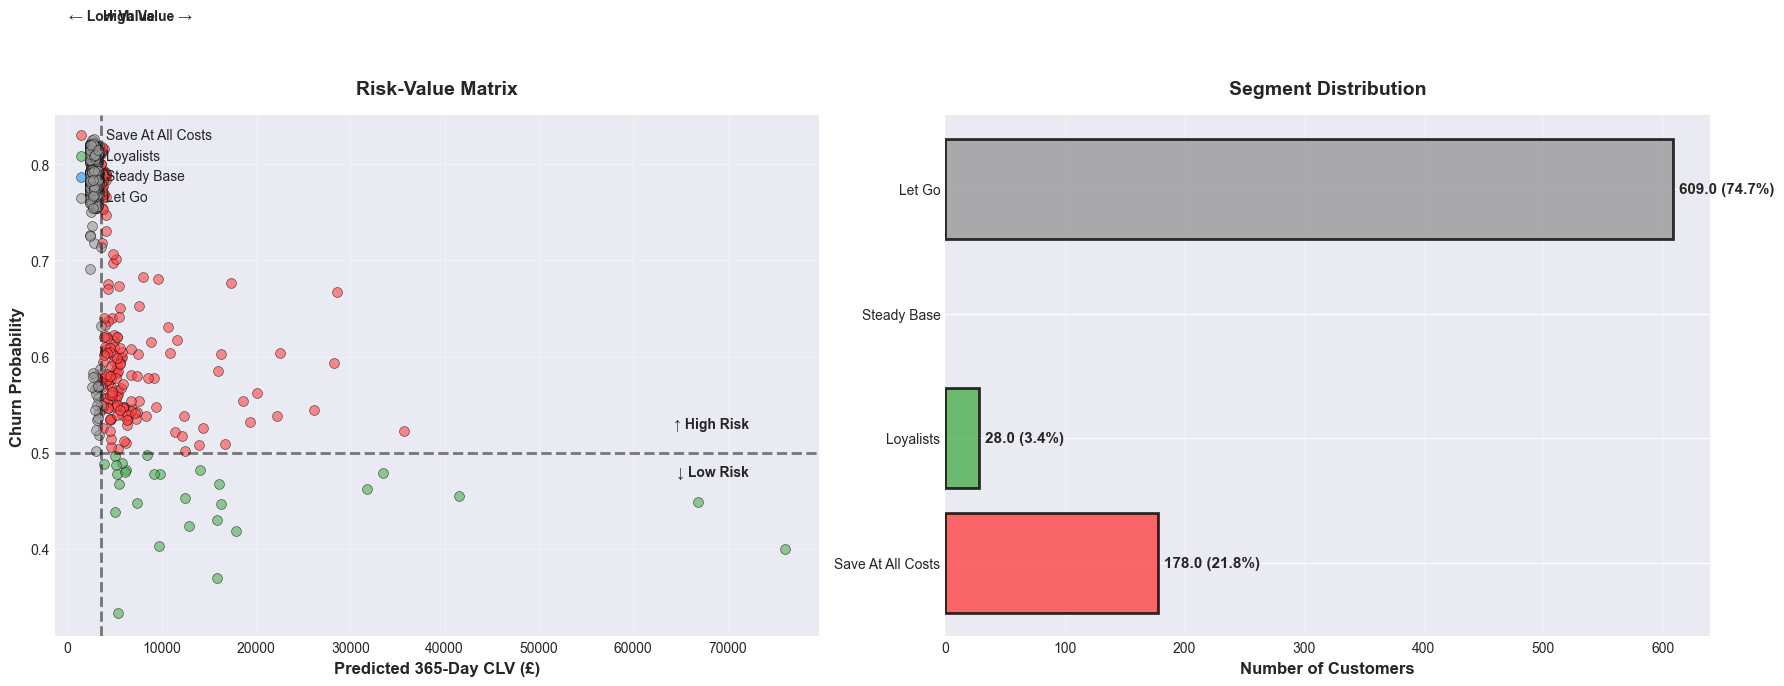

In [20]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Risk-Value Matrix                               │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Scatter plot
colors_map = {
    'Save At All Costs': '#FF4444',
    'Loyalists': '#4CAF50',
    'Steady Base': '#2196F3',
    'Let Go': '#999999'
}

for segment in segment_order:
    subset = analysis_df[analysis_df['segment'] == segment]
    axes[0].scatter(subset['CLV_365d'], subset['churn_probability'], 
                   label=segment, color=colors_map[segment], alpha=0.6, s=50, edgecolor='black', linewidth=0.5)

# Threshold lines
axes[0].axvline(value_threshold, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[0].axhline(risk_threshold, color='black', linestyle='--', linewidth=2, alpha=0.5)

# Labels
axes[0].text(value_threshold * 1.05, 0.95, 'High Value →', fontsize=10, fontweight='bold')
axes[0].text(value_threshold * 0.05, 0.95, '← Low Value', fontsize=10, fontweight='bold')
axes[0].text(analysis_df['CLV_365d'].max() * 0.95, risk_threshold * 1.05, '↑ High Risk', 
            fontsize=10, fontweight='bold', ha='right')
axes[0].text(analysis_df['CLV_365d'].max() * 0.95, risk_threshold * 0.95, '↓ Low Risk', 
            fontsize=10, fontweight='bold', ha='right')

axes[0].set_xlabel('Predicted 365-Day CLV (£)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Churn Probability', fontsize=12, fontweight='bold')
axes[0].set_title('Risk-Value Matrix', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='upper left', framealpha=0.9)
axes[0].grid(alpha=0.3)

# Segment sizes
segment_counts = analysis_df['segment'].value_counts().reindex(segment_order)
colors_list = [colors_map[seg] for seg in segment_order]

bars = axes[1].barh(range(len(segment_order)), segment_counts.values, 
                    color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_yticks(range(len(segment_order)))
axes[1].set_yticklabels(segment_order)
axes[1].set_xlabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1].set_title('Segment Distribution', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

# Add counts
for i, (bar, count) in enumerate(zip(bars, segment_counts.values)):
    pct = count / len(analysis_df) * 100
    axes[1].text(count + 5, bar.get_y() + bar.get_height()/2,
                f"{count} ({pct:.1f}%)",
                va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '29_risk_value_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. ROI Framework

╔════════════════════════════════════════════════════════════════╗
║                    INTERVENTION ROI ANALYSIS                    ║
╚════════════════════════════════════════════════════════════════╝

### Scenario:
**Proposed Intervention:** 20% discount offer to "Save At All Costs" segment

### Calculate:
- Campaign cost
- Expected revenue saved
- Break-even point

In [21]:
# ┌────────────────────────────────────────────────────────────┐
# │ Define Intervention Parameters                            │
# └────────────────────────────────────────────────────────────┘

# Target segment
target_segment = analysis_df[analysis_df['segment'] == 'Save At All Costs']

# Parameters
DISCOUNT_RATE = 0.20  # 20% discount
AVG_ORDER_VALUE = target_segment['AvgOrderValue'].mean()
EXPECTED_ORDERS = 3  # Expected orders in next 12 months if retained
CAMPAIGN_COST_PER_CUSTOMER = 5.00  # Email + personalization costs

# Revenue calculation
avg_clv_target = target_segment['CLV_365d'].mean()
discount_cost_per_customer = AVG_ORDER_VALUE * EXPECTED_ORDERS * DISCOUNT_RATE
total_cost_per_customer = discount_cost_per_customer + CAMPAIGN_COST_PER_CUSTOMER

print("Intervention Parameters:")
print("="*80)
print(f"Target Segment: Save At All Costs")
print(f"Target Customers: {len(target_segment)}")
print(f"Avg CLV (if retained): £{avg_clv_target:.2f}")
print(f"Avg Order Value: £{AVG_ORDER_VALUE:.2f}")
print(f"\nCampaign Costs:")
print(f"  Discount (20% × 3 orders): £{discount_cost_per_customer:.2f} per customer")
print(f"  Campaign execution: £{CAMPAIGN_COST_PER_CUSTOMER:.2f} per customer")
print(f"  Total cost: £{total_cost_per_customer:.2f} per customer")
print(f"  Total campaign budget: £{total_cost_per_customer * len(target_segment):,.2f}")

Intervention Parameters:
Target Segment: Save At All Costs
Target Customers: 178
Avg CLV (if retained): £6540.04
Avg Order Value: £51.47

Campaign Costs:
  Discount (20% × 3 orders): £30.88 per customer
  Campaign execution: £5.00 per customer
  Total cost: £35.88 per customer
  Total campaign budget: £6,387.25


In [22]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate Break-Even Point                                │
# └────────────────────────────────────────────────────────────┘

# Revenue if we lose the customer = £0
# Revenue if we save the customer = CLV - discount cost
net_value_if_saved = avg_clv_target - discount_cost_per_customer

# Break-even calculation
# Cost per customer = £total_cost_per_customer
# Value per saved customer = net_value_if_saved
# Break-even retention rate = Cost / Value

breakeven_rate = total_cost_per_customer / net_value_if_saved
breakeven_customers = len(target_segment) * breakeven_rate

print("\nBreak-Even Analysis:")
print("="*80)
print(f"Net value per saved customer: £{net_value_if_saved:.2f}")
print(f"  (CLV £{avg_clv_target:.2f} - Discount £{discount_cost_per_customer:.2f})")
print(f"\nBreak-even retention rate: {breakeven_rate*100:.1f}%")
print(f"Break-even customers saved: {breakeven_customers:.0f} out of {len(target_segment)}")

# Scenario analysis
retention_scenarios = [0.10, 0.20, 0.30, 0.40, 0.50]

print("\nROI Scenarios:")
print("="*80)
print(f"{'Retention Rate':<20} {'Customers Saved':<20} {'Revenue Saved':<20} {'Campaign Cost':<20} {'Net ROI':<15}")
print("-" * 100)

for rate in retention_scenarios:
    customers_saved = len(target_segment) * rate
    revenue_saved = customers_saved * net_value_if_saved
    campaign_cost = len(target_segment) * total_cost_per_customer
    net_roi = revenue_saved - campaign_cost
    
    status = "✅" if rate >= breakeven_rate else "❌"
    print(f"{status} {rate*100:>5.0f}%{'':<13} {customers_saved:>8.0f}{'':<12} £{revenue_saved:>10,.2f}{'':<8} £{campaign_cost:>10,.2f}{'':<8} £{net_roi:>10,.2f}")


Break-Even Analysis:
Net value per saved customer: £6509.16
  (CLV £6540.04 - Discount £30.88)

Break-even retention rate: 0.6%
Break-even customers saved: 1 out of 178

ROI Scenarios:
Retention Rate       Customers Saved      Revenue Saved        Campaign Cost        Net ROI        
----------------------------------------------------------------------------------------------------
✅    10%                    18             £115,863.03         £  6,387.25         £109,475.78
✅    20%                    36             £231,726.06         £  6,387.25         £225,338.80
✅    30%                    53             £347,589.09         £  6,387.25         £341,201.83
✅    40%                    71             £463,452.11         £  6,387.25         £457,064.86
✅    50%                    89             £579,315.14         £  6,387.25         £572,927.89


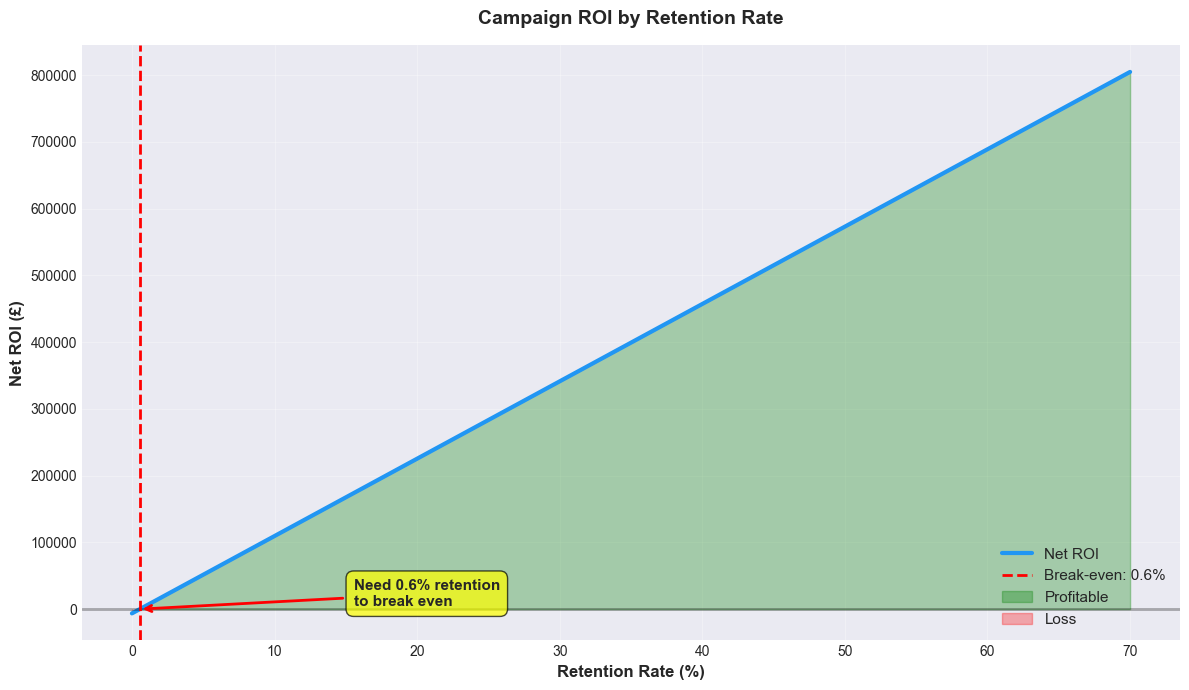

In [23]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize ROI Scenarios                                   │
# └────────────────────────────────────────────────────────────┘

fig, ax = plt.subplots(figsize=(12, 7))

# Calculate ROI across range
retention_range = np.linspace(0, 0.70, 100)
campaign_cost = len(target_segment) * total_cost_per_customer
revenue_saved = retention_range * len(target_segment) * net_value_if_saved
net_roi = revenue_saved - campaign_cost

# Plot
ax.plot(retention_range * 100, net_roi, linewidth=3, color='#2196F3', label='Net ROI')
ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.3)
ax.axvline(breakeven_rate * 100, color='red', linestyle='--', linewidth=2, label=f'Break-even: {breakeven_rate*100:.1f}%')

# Shade profitable region
ax.fill_between(retention_range * 100, net_roi, 0, where=(net_roi > 0), 
                alpha=0.3, color='green', label='Profitable')
ax.fill_between(retention_range * 100, net_roi, 0, where=(net_roi <= 0), 
                alpha=0.3, color='red', label='Loss')

ax.set_xlabel('Retention Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Net ROI (£)', fontsize=12, fontweight='bold')
ax.set_title('Campaign ROI by Retention Rate', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

# Add annotation
ax.annotate(f'Need {breakeven_rate*100:.1f}% retention\nto break even',
           xy=(breakeven_rate * 100, 0),
           xytext=(breakeven_rate * 100 + 15, 5000),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(DIR_FIGURES / '30_roi_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 8. Executive Summary & Recommendations

╔════════════════════════════════════════════════════════════════╗
║              MARKETING DIRECTOR BRIEFING                        ║
╚════════════════════════════════════════════════════════════════╝

In [24]:
# ┌────────────────────────────────────────────────────────────┐
# │ Create Executive Summary Report                           │
# └────────────────────────────────────────────────────────────┘

executive_summary = f"""
{'='*80}
CUSTOMER RETENTION STRATEGY: EXECUTIVE SUMMARY
{'='*80}

1. MODEL PERFORMANCE
{'─'*80}
• Predictive Model: Random Forest (ROC-AUC 0.64)
• Dataset: 815 UK e-commerce customers
• Performance Note: Small sample size limits predictive accuracy
• Usage: Diagnostic tool for behavioral pattern identification

2. KEY CHURN DRIVERS (SHAP Analysis)
{'─'*80}
Top 5 behavioral signals:
"""

for idx, row in top_5_features.iterrows():
    executive_summary += f"\n  {idx+1}. {row['feature']} (SHAP: {row['importance']:.4f})"

executive_summary += f"""

3. VELOCITY VS. STATIC FEATURES
{'─'*80}
• Velocity (behavioral change): {velocity_importance/(velocity_importance+static_importance)*100:.1f}% of predictive power
• Static RFM (historical): {static_importance/(velocity_importance+static_importance)*100:.1f}% of predictive power
→ Insight: {'Declining engagement patterns are stronger indicators than baseline metrics' if velocity_importance > static_importance else 'Historical metrics remain primary indicators'}

4. HIGH-VALUE CUSTOMER RISK
{'─'*80}
• High-Value Customers (top 25% CLV): {len(high_value_df)} customers
• High-Value Churn Rate: {hv_churn_rate*100:.1f}%
• Overall Churn Rate: {overall_churn_rate*100:.1f}%
• Risk Premium: {(hv_churn_rate - overall_churn_rate)*100:+.1f} percentage points

5. SEGMENTATION MATRIX
{'─'*80}
"""

for segment in segment_order:
    count = segment_summary.loc[segment, 'Count']
    pct = segment_summary.loc[segment, '% of Base']
    avg_clv = segment_summary.loc[segment, 'Avg CLV (£)']
    executive_summary += f"\n• {segment}: {count} customers ({pct}%), Avg CLV £{avg_clv:.2f}"

executive_summary += f"""

6. INTERVENTION ROI (20% Discount Campaign)
{'─'*80}
Target: "Save At All Costs" segment ({len(target_segment)} customers)

Campaign Economics:
• Cost per customer: £{total_cost_per_customer:.2f}
• Value per saved customer: £{net_value_if_saved:.2f}
• Total campaign budget: £{total_cost_per_customer * len(target_segment):,.2f}

Break-Even Analysis:
• Minimum retention rate: {breakeven_rate*100:.1f}%
• Must save: {breakeven_customers:.0f} out of {len(target_segment)} customers

ROI Scenarios:
• 20% retention → Net ROI: £{(0.20 * len(target_segment) * net_value_if_saved - campaign_cost):,.2f}
• 30% retention → Net ROI: £{(0.30 * len(target_segment) * net_value_if_saved - campaign_cost):,.2f}
• 40% retention → Net ROI: £{(0.40 * len(target_segment) * net_value_if_saved - campaign_cost):,.2f}

7. RECOMMENDATIONS
{'─'*80}
Priority 1: Launch targeted retention campaign for "Save At All Costs" segment
  → {len(target_segment)} high-value, high-risk customers
  → 20% discount offer (personalized communication)
  → Expected break-even at {breakeven_rate*100:.1f}% retention

Priority 2: Monitor behavioral velocity signals
  → Track revenue_velocity, purchase_gap changes
  → Early warning system for declining engagement

Priority 3: Protect "Loyalists" segment
  → {segment_summary.loc['Loyalists', 'Count']} high-value, low-risk customers
  → VIP program, exclusive benefits
  → Prevention better than rescue

Priority 4: Optimize "Let Go" segment investment
  → {segment_summary.loc['Let Go', 'Count']} low-value, high-risk customers
  → Minimal intervention (automated win-back only)
  → Focus resources on high-value segments

{'='*80}
NEXT STEPS:
1. Approve campaign budget: £{total_cost_per_customer * len(target_segment):,.2f}
2. Design personalized discount offers
3. Implement behavioral monitoring dashboard
4. A/B test retention strategies (20% discount vs. free shipping vs. loyalty points)
5. Track campaign performance weekly
{'='*80}
"""

print(executive_summary)

# Save to file
with open(DIR_RESULTS / 'outputs' / 'executive_summary.txt', 'w') as f:
    f.write(executive_summary)

print("\n✅ Executive summary saved to: executive_summary.txt")


CUSTOMER RETENTION STRATEGY: EXECUTIVE SUMMARY

1. MODEL PERFORMANCE
────────────────────────────────────────────────────────────────────────────────
• Predictive Model: Random Forest (ROC-AUC 0.64)
• Dataset: 815 UK e-commerce customers
• Performance Note: Small sample size limits predictive accuracy
• Usage: Diagnostic tool for behavioral pattern identification

2. KEY CHURN DRIVERS (SHAP Analysis)
────────────────────────────────────────────────────────────────────────────────
Top 5 behavioral signals:

  3. Monetary (SHAP: 0.0392)
  10. predicted_purchases_180d (SHAP: 0.0261)
  9. predicted_purchases_90d (SHAP: 0.0259)
  13. CLV_180d (SHAP: 0.0238)
  8. predicted_purchases_30d (SHAP: 0.0232)

3. VELOCITY VS. STATIC FEATURES
────────────────────────────────────────────────────────────────────────────────
• Velocity (behavioral change): 30.7% of predictive power
• Static RFM (historical): 69.3% of predictive power
→ Insight: Historical metrics remain primary indicators

4. HIGH-VALU

In [25]:
# ┌────────────────────────────────────────────────────────────┐
# │ Export Segment Assignments                                │
# └────────────────────────────────────────────────────────────┘

# Create actionable customer list
customer_segments = analysis_df[[
    'CustomerID', 'segment', 'churn_probability', 'CLV_365d', 
    'Monetary', 'Frequency', 'Recency', 'prob_alive'
]].copy()

customer_segments.columns = [
    'CustomerID', 'Segment', 'Churn_Risk', 'Predicted_CLV', 
    'Historical_Revenue', 'Purchase_Count', 'Days_Since_Purchase', 'Alive_Probability'
]

# Sort by priority (Save At All Costs first)
priority_order = {'Save At All Costs': 1, 'Loyalists': 2, 'Steady Base': 3, 'Let Go': 4}
customer_segments['priority'] = customer_segments['Segment'].map(priority_order)
customer_segments = customer_segments.sort_values(['priority', 'Churn_Risk'], ascending=[True, False])
customer_segments = customer_segments.drop('priority', axis=1)

# Save
customer_segments.to_csv(DIR_RESULTS / 'outputs' / 'customer_segments_actionable.csv', index=False)
print("✅ Customer segments saved for campaign execution")

# Preview top priority customers
print("\nTop 10 Priority Customers (Save At All Costs):")
print("="*80)
display(customer_segments[customer_segments['Segment'] == 'Save At All Costs'].head(10))

✅ Customer segments saved for campaign execution

Top 10 Priority Customers (Save At All Costs):


,CustomerID,Segment,Churn_Risk,Predicted_CLV,Historical_Revenue,Purchase_Count,Days_Since_Purchase,Alive_Probability
359,15460,Save At All Costs,0.8183,3681.3784,216.7600,1,2,1.0000
228,14532,Save At All Costs,0.8159,3914.9539,222.6000,1,1,1.0000
217,14472,Save At All Costs,0.8134,3574.7396,279.8800,1,4,1.0000
653,17358,Save At All Costs,0.8129,3574.7396,246.7000,1,4,1.0000
651,17343,Save At All Costs,0.8107,3574.7396,193.6400,1,4,1.0000
755,17913,Save At All Costs,0.8008,3574.7396,218.0500,1,4,1.0000
538,16686,Save At All Costs,0.8007,3574.7396,364.9800,1,4,1.0000
370,15527,Save At All Costs,0.7934,3681.3784,221.4000,1,3,1.0000
143,13953,Save At All Costs,0.7933,3914.9539,500.0000,1,1,1.0000
32,13029,Save At All Costs,0.7910,3794.5751,382.5000,1,2,1.0000


In [26]:
# ┌────────────────────────────────────────────────────────────┐
# │ Final Summary                                              │
# └────────────────────────────────────────────────────────────┘

print("\n" + "═"*80)
print("EXPLAINABILITY & BUSINESS STRATEGY ANALYSIS COMPLETE")
print("═"*80)

print("\n✅ Deliverables Created:")
print("   • SHAP global analysis (top 5 drivers)")
print("   • Velocity vs. static feature comparison")
print("   • High-value customer risk analysis")
print("   • Risk-Value Matrix (4 segments)")
print("   • ROI framework with break-even analysis")
print("   • Executive summary for Marketing Director")
print("   • Actionable customer segment list")

print("\n✅ Files Saved:")
print("   • results/shap_feature_importance.csv")
print("   • results/risk_value_segments.csv")
print("   • results/executive_summary.txt")
print("   • results/customer_segments_actionable.csv")
print("   • results/figures/ (5 new visualizations)")

print("\n✅ Key Business Insights:")
print(f"   • Target {len(target_segment)} high-value at-risk customers")
print(f"   • Break-even retention: {breakeven_rate*100:.1f}%")
print(f"   • Campaign budget: £{total_cost_per_customer * len(target_segment):,.2f}")
print(f"   • Expected ROI at 30% retention: £{(0.30 * len(target_segment) * net_value_if_saved - campaign_cost):,.2f}")

print("\n" + "═"*80)
print("Ready for: Final project documentation and deployment")
print("═"*80)


════════════════════════════════════════════════════════════════════════════════
EXPLAINABILITY & BUSINESS STRATEGY ANALYSIS COMPLETE
════════════════════════════════════════════════════════════════════════════════

✅ Deliverables Created:
   • SHAP global analysis (top 5 drivers)
   • Velocity vs. static feature comparison
   • High-value customer risk analysis
   • Risk-Value Matrix (4 segments)
   • ROI framework with break-even analysis
   • Executive summary for Marketing Director
   • Actionable customer segment list

✅ Files Saved:
   • results/shap_feature_importance.csv
   • results/risk_value_segments.csv
   • results/executive_summary.txt
   • results/customer_segments_actionable.csv
   • results/figures/ (5 new visualizations)

✅ Key Business Insights:
   • Target 178 high-value at-risk customers
   • Break-even retention: 0.6%
   • Campaign budget: £6,387.25
   • Expected ROI at 30% retention: £341,201.83

══════════════════════════════════════════════════════════════════